In [1]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

### ADAM: Generate OD coordinate labels from OD masks

Set the `data_root` to the folder containing the extracted ADAM dataset folder:
- "data_root"
    - "ADAM"
        - "DF-Annotation-Training400"
        - ...

In [2]:
data_root = Path("../../fovea_detection/")

Then, run the following code to generate a file of OD coordinate metadata at `data_root`.

In [5]:
# Load OD masks (.bmp)
masks_path = data_root.joinpath("ADAM/DF-Annotation-Training400/Training400/Disc_Masks/")
mask_filenames = os.listdir(masks_path)
mask_filenames = [p for p in mask_filenames if p.endswith('.bmp')]

masks = {f: plt.imread(masks_path / f) for f in mask_filenames}

no_od = []

for f, mask in masks.items():
    if np.all(mask == 255):
        no_od.append(f)
len(no_od)

130

In [6]:
len(mask_filenames)

400

Display images without OD labels.

In [8]:
images_path = data_root.joinpath("ADAM/AMD-Training400/Training400/")
# for f in no_od:
#     subfolder = "AMD/" if f.startswith('A') else "Non-AMD/"
#     # size 200x200
#     fig = plt.figure(figsize=(2, 2))
#     plt.imshow(plt.imread(images_path + subfolder + f.replace('bmp', 'jpg')))
#     plt.axis('off')
#     plt.close()

-> Some do have ODs, so we cannot just use the non-label to learn an absence of the OD.

In [9]:
# Save exclude list to file
with open(data_root.joinpath('ADAM_no_od_mask.txt'), 'w') as f:
    for item in no_od:
        f.write("%s\n" % item.replace('.bmp', '.jpg'))

In [12]:
# Get coordinates of OD by center of mass of mask in x and y
masks = {f: plt.imread(masks_path / f) for f in mask_filenames if f not in no_od}
centroids = {}

for f, mask in masks.items():
    y, x = np.where(mask == 0)
    y = np.mean(y)
    x = np.mean(x)
    centroids[f] = (x, y)

df = pd.DataFrame(columns=['imgName', 'OD_X', 'OD_Y'])
df['imgName'] = centroids.keys()
df['imgName'] = df['imgName'].apply(lambda x: x.replace('.bmp', '.jpg'))
df['OD_X'] = [c[0] for c in centroids.values()]
df['OD_Y'] = [c[1] for c in centroids.values()]
df.sort_values('imgName', inplace=True)

df.to_excel(data_root.joinpath('ADAM_OD_location.xlsx'), index=False)

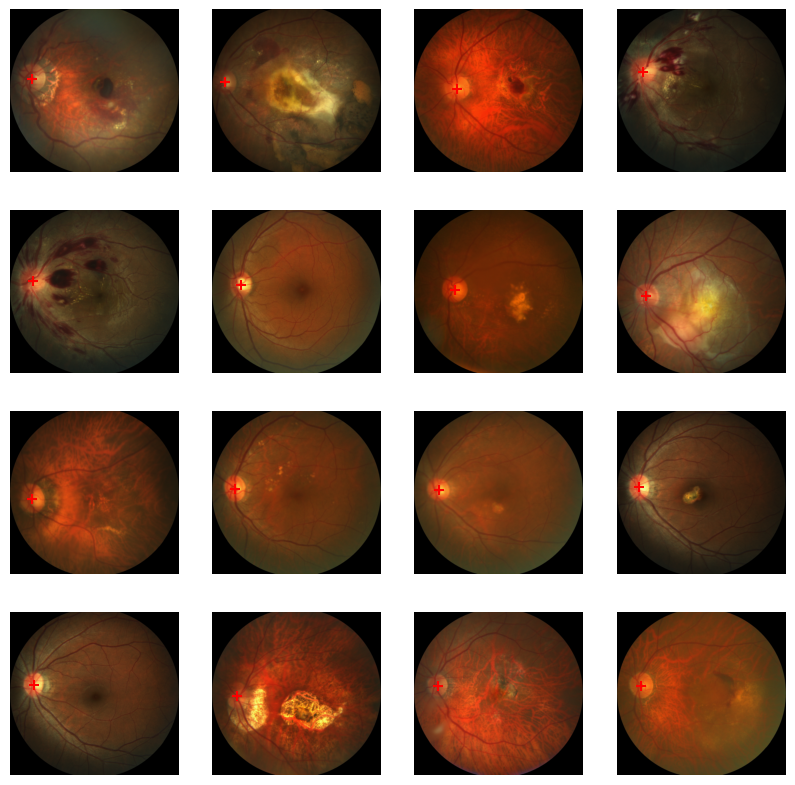

In [14]:
# Plot some imgs with the extracted centroid
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.axis('off')
    f = df.iloc[i]['imgName']
    subfolder = "AMD/" if f.startswith('A') else "Non-AMD/"
    img = plt.imread(images_path / subfolder / f)
    ax.imshow(img)
    m = f.replace('jpg', 'bmp')
    ax.scatter(centroids[m][0], centroids[m][1], c='r', s=50, marker="+")
    
plt.show()
plt.close()